In [3]:
#!/usr/bin/python


from __future__ import print_function
import tensorflow as tf
import pandas
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from scipy.optimize import NonlinearConstraint, LinearConstraint
from scipy.optimize import BFGS, minimize, Bounds, SR1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
import numpy
from keras.models import model_from_json, load_model
from pathlib import Path
import os.path
import time
import os
import math
import pyipopt
from numpy import *
#####Simulation time step
delta=0.01
hc=1e-4 #delta/100
oper_time=0.01

short_factor=int(0.01/delta)
####Initial states
CAi=-1.5
Ti=70
x1_nn=CAi
x2_nn=Ti
x1_record=[CAi]
x2_record=[Ti]
u1_record=[]
u2_record=[]
time_record=[]


a=1060
b=22
d=0.52

F=5
V=1
k0=8460000
E=50000
R=8.314
T0=300
Dh=-11500
rho=1000
sigma=1000
Cp=0.231
cp=0.231
Qs=0
CA0s=4
x_record=[0,0]
#steady-state
CAs= 1.9537
Ts=  401.8727

w1_std=2.5
w2_std=70
state_ss=numpy.array([Ts, CAs])
input_ss=numpy.array([Qs, CA0s])




ROOT_FOLDER=os.getcwd()
#### CONSTANTS ####
NUM_MPC_ITERATION=20*short_factor   #10000000000

OUTPUT_NO=0
TOTAL_MODELS=12 # used to be 8
NUM_SUBMODELS=1
NUM_OUTPUTS=2
NUM_INPUTS=4   #used to be 16
HORIZON=2
#NUM_CONSTRAINT_MODELS=3
NUM_IN_SEQUENCE=20
PREDICTION_STORE=0
#NUM_PREDICTION_STEPS=1
deviation=0
NUM_MPC_INPUTS=2*HORIZON
NUM_MPC_CONSTRAINTS=HORIZON
realtime_data=None
setpoint=[0, 0]

 


def my_ens_prediction(num_horizon,my_rawdata,my_inputs):
    xx = []
    nn_inputs = []
    ensemble_output = numpy.zeros((num_horizon,NUM_OUTPUTS,NUM_IN_SEQUENCE))
    #numpy.array([0]*(num_horizon*NUM_OUTPUTS*NUM_IN_SEQUENCE))#[[[0 for i in range(NUM_IN_SEQUENCE)] for j in range(NUM_OUTPUTS)] for j in range(NUM_IN_SEQUENCE)]
    ensemble_output = ensemble_output.reshape(num_horizon,NUM_IN_SEQUENCE,NUM_OUTPUTS)
    predict_output = []
    x_test2 = my_rawdata[0:NUM_OUTPUTS].astype(float)
    x_test2= (x_test2-state_mean)/state_std

    predict_output_normal=[[0 for i in range(NUM_OUTPUTS)] for j in range(NUM_IN_SEQUENCE)]
    for i_model in range(num_horizon):    
        # i_model=0
        # my_inputs=[640]*4    
        COUNT_CORRECT_MODEL=0
        my_inputs_normalized = (my_inputs[2*i_model:2*(i_model+1)] - input_mean) / input_std
        sum=[[0 for i in range(NUM_OUTPUTS)] for j in range(NUM_IN_SEQUENCE)]
        xx = numpy.concatenate((x_test2,  my_inputs_normalized), axis=None).reshape((1, NUM_INPUTS))
        xx = numpy.tile(xx, (NUM_IN_SEQUENCE, 1))
        #if i_model != 0:
        #    xx[:,NUM_OUTPUTS:2*NUM_OUTPUTS]=predict_output_normal
        nn_inputs = xx.reshape(1, NUM_IN_SEQUENCE, NUM_INPUTS)
        for j_submodel in range (NUM_SUBMODELS):
            # j_submodel=0
            predict_output = numpy.array(model[j_submodel].predict(nn_inputs))
            predict_output = predict_output.reshape(NUM_IN_SEQUENCE, NUM_OUTPUTS)
            # print ("submodel id:", j_submodel)
            # print ("submodel:", predict_output)
            #if not math.isnan(predict_output[0,0]):
            sum=sum+predict_output
            #COUNT_CORRECT_MODEL=COUNT_CORRECT_MODEL+1
        # MODEL AVERAGING (ENSEMBLE LEARNING)
        predict_output=sum/NUM_SUBMODELS
        #print (predict_output.shape)
        x_test2=predict_output[-1,0:2]

        #########  if delta=0.005##########
        #x_test2=predict_output[int(NUM_IN_SEQUENCE/2-1),0:2]
        x_test2 = predict_output[int(NUM_IN_SEQUENCE/short_factor-1), 0:2]
        x_test2=x_test2 * output_std + output_mean
        x_test2 = (x_test2 - state_mean) / state_std


        # RESCALING BY THE CORRESPONDING STANDARD DEVIATION & THE MEAN OF THE OUTPUT STATISTICS OF THE EXITING SURFACE
        predict_output_normal = predict_output * output_std + output_mean
        #predict_output_normal=predict_output_normal*[y2_std, y1_std]+[y2_mean, y1_mean]
        #print("predict_output_normal=",predict_output_normal)
        #print("ensemble_output=",ensemble_output.shape)
        ensemble_output[i_model,:,:]=predict_output_normal

    return ensemble_output    



#################################################
################## MPC PROGRAM ##################
#################################################
### DEFINE THE UPPER BOUND AND LOWER BOUND OF THE MANIPULATED INPUTS ###

def eval_f(x):
    assert len(x) == int(NUM_MPC_INPUTS)
    offset=0
    global PREDICTION_STORE
    #### CALCULATE OUTLET CONC ###########
    df_ensemble_output = my_ens_prediction(num_horizon=int(NUM_MPC_INPUTS/2),my_rawdata=realtime_data,my_inputs=x)
    # LAST SUBENSEMBLE, LAST TIME STEP, FIRST VARIABLE
    # factor=realtime_data[1] **2 *500 /(realtime_data[0] **2 *50)
    # factor2=realtime_data[1] **2 *500 /(3.5 **2 *100)
    #### account for all intermediate steps ####
    for j in range (int(NUM_MPC_INPUTS/2)):
        est_outlet_product = df_ensemble_output[j, :, 0:2]
        for i in range (int(NUM_IN_SEQUENCE/short_factor)):  #NUM_IN_SEQUENCE/2
             #print ("just show:", est_outlet_product[i,:])
            #offset = offset+ (setpoint[0]-(est_outlet_product[i,0]-Ts)) ** 2.0 *2 +(setpoint[1]-(est_outlet_product[i,1]-CAs)) ** 2.0 *500 +\
             #    x[2*j] **2 *5e-6 + 0.6* x[2*j+1] **2
             #offset = offset+(setpoint[0]-(est_outlet_product[i,0]-Ts)) ** 2.0 *factor +(setpoint[1]-(est_outlet_product[i,1]-CAs)) ** 2.0 *500 +\
             #     0#x[2*j] **2 *1e-10 + 1* x[2*j+1] **2

             offset = offset + (setpoint[0] - (est_outlet_product[i, 0])) ** 2.0  + (setpoint[1] - (est_outlet_product[i, 1])) ** 2.0 * 1000
        offset=offset+x[2*j] **2 *3e-10 + 1* x[2*j+1] **2
        #offset=offset+(x[1]-x_record[1])**2 *factor2/10+(x[0]-x_record[0])**2 *factor2/1e11



    #print ("im here")
    #####  only account for the last point #####
    # for j in range(int(NUM_MPC_INPUTS / 2)):
    #     est_outlet_product = df_ensemble_output[j, -1, 0:2]
    #     #for i in range(NUM_IN_SEQUENCE):
    #     offset = offset+ (setpoint[0] - (est_outlet_product[0] - Ts)) ** 2.0 + (
    #                 setpoint[1] - (est_outlet_product[1] - CAs)) ** 2.0 * 500 + \
    #              0#x[2*j] ** 2 * 1e-11 + 0.05 * x[2*j+1] ** 2

    # useless for now
    #PREDICTION_STORE=numpy.asscalar(est_outlet_product)
    #print("Prediction store:", PREDICTION_STORE)
    #print ("obj func:  ", numpy.asarray(offset))
    return offset/100

def eval_grad_f(x):
    assert len(x) == int(NUM_MPC_INPUTS)
    step = 1e-1 # we just have a small step
    objp=objm=0
    grad_f = [0]*NUM_MPC_INPUTS
    xpstep = [0]*NUM_MPC_INPUTS
    xmstep = [0]*NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep=x.copy()
        xmstep=x.copy()
        # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
        xpstep[i_mpc_input]  = xpstep[i_mpc_input]+step 
        xmstep[i_mpc_input] = xmstep[i_mpc_input]-step
        #print ("step: ", step)
        #print ("xp:  ",xpstep)
        #print ("xm:  ",xmstep)
        #print ("i_mpc_input:  ",i_mpc_input)
        # Evaluate the objective function at xpstep and xmstep
        objp=eval_f(xpstep) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed +step
        objm=eval_f(xmstep) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed -step
        #print ("obj ", objp, "   objm   ", objm)
        grad_f[i_mpc_input] = (objp - objm) / (2 * step) # This evaluates the gradient of the objetive function with repect to the optimization variable x[i]
    #print("Gradient: ", grad_f)
    return array(grad_f)

def eval_g(x):
    assert len(x) == int(NUM_MPC_INPUTS)
    #### CALCULATE FLUID TEMPERATURE ALONG THE FIRST THREE SURFACES ###########
    #df_ensemble_output = my_ens_prediction(num_horizon=NUM_CONSTRAINT_MODELS,my_rawdata=realtime_data,my_inputs=x)
    CAd2=realtime_data[1]
    Td2=realtime_data[0]
    ##pred_states=df_ensemble_output[-1, -1, 0:2]
    #CAd2=df_ensemble_output[-1, -1, 1]
    #Td2
    g=array([-5.0]*NUM_MPC_CONSTRAINTS)
    #print ("gggg", g)

    if ((a*CAd2**2+d*Td2**2+2*b*CAd2*Td2-2)> 0):
        # LfV = (2 * a * CAd2 + 2 * b * Td2) * ((F / V) * (-CAd2) - k0 * ((numpy.exp(-E / (R * (Td2 + Ts))) * (CAd2 + CAs) ** 2)-
        #                                                                 numpy.exp(-E / (R * Ts)) *(CAs)**2)) + \
        #       (2 * d * Td2 + 2 * b * CAd2) * (((F / V) * (-Td2) + (-Dh / (sigma * cp)) *
        #                                        (k0 * ((numpy.exp(-E / (R * (Td2 + Ts))) *(CAd2 + CAs) ** 2) - numpy.exp(-E / (R * Ts)) * CAs ** 2))))

        # LgV = (2 * d * Td2 + 2 * b * CAd2) / (V * sigma * cp)

        # h2x = -(LfV + sqrt((LfV ** 2) + LgV ** 4)) / (LgV)


        # if (h2x > 5e5):
        #     h2x=5e5

        # if (h2x < -5e5):
        #     h2x=-5e5

        # dot_Vt = (2 * a * CAd2 + 2 * b * Td2) * ((F / V) * (0 - CAd2) -
        #                                          k0 * ((numpy.exp(-E / (R * (Td2 + Ts))) * (
        #                     CAd2 + CAs) ** 2) - numpy.exp(
        #             -E / (R * Ts)) * (CAs ** 2))) + \
        #          (2 * d * Td2 + 2 * b * CAd2) * (((F / V) * (-Td2) + (-Dh / (sigma * cp)) * (
        #         k0 * ((numpy.exp(-E / (R * (Td2 + Ts))) * (CAd2 + CAs) ** 2) -
        #               numpy.exp(-E / (R * Ts)) * CAs ** 2)) + (h2x / (sigma * cp * V))))
        # #print("theoretic dot v=:  ", dot_Vt)

        # dot_V=(2*a * CAd2 + 2*b * Td2)*((F / V)*(x[1] - CAd2) -
        #        k0*((numpy.exp(-E / (R*(Td2 + Ts)))* (CAd2 + CAs) ** 2) - numpy.exp(-E / (R*Ts))*(CAs ** 2))) + \
        #     (2*d*Td2 + 2*b * CAd2)*(((F / V)*(-Td2) + (-Dh / (sigma*cp))*(k0*((numpy.exp(-E / (R*(Td2 + Ts)))* (CAd2 + CAs)** 2) -
        #       numpy.exp(-E / (R*Ts))* CAs ** 2)) + (x[0] / (sigma*cp*V))))
        #print ("dot V- TRUE", dot_V)

        df_ensemble_output3 = my_ens_prediction(num_horizon=1,my_rawdata=realtime_data, my_inputs=x)
        est_outlet = df_ensemble_output3[-1, -1, 0:2].reshape(1,2)
        dot_V1=(2*a * CAd2 + 2*b * Td2)*((est_outlet[0][1])-CAd2)/(0.01)+\
                (2*d*Td2 + 2*b * CAd2)*((est_outlet[0][0])-Td2)/(0.01)
        #print ("dot V", dot_V1)

        vv=a*CAd2**2+d*Td2**2+2*b*CAd2*Td2
        g[0]=dot_V1+15*abs(vv/100)

        #g[0]=dot_V-dot_Vt#+1#e-2 

    else:
        df_ensemble_output2 = my_ens_prediction(num_horizon=int(NUM_MPC_INPUTS / 2), my_rawdata=realtime_data,
                                               my_inputs=x)
        # LAST SUBENSEMBLE, LAST TIME STEP, FIRST VARIABLE

        #### NORMALIZE SETPOINT ####
        # for j in range (int(NUM_MPC_INPUTS/2)):
        #     est_outlet_product = df_ensemble_output[j, :, 0:2]
        #     for i in range (NUM_IN_SEQUENCE):
        #         offset = (setpoint[0]-(est_outlet_product[i,0]-Ts)) ** 2.0 +(setpoint[1]-(est_outlet_product[i,1]-CAs)) ** 2.0 *500 +\
        #              x[0] **2 *1e-11 + 0.05* x[1] **2

        #####  only account for the last point #####
        for j in range(int(NUM_MPC_INPUTS / 2)):
            est_outlet_product2 = df_ensemble_output2[j, int(NUM_IN_SEQUENCE/short_factor-1), 0:2]  #int(NUM_IN_SEQUENCE/2-1)
            # for i in range(NUM_IN_SEQUENCE):
            g[j]= d * (est_outlet_product2[0]) ** 2+ 2 * b * (est_outlet_product2[0])*(est_outlet_product2[1]) + \
                  a*(est_outlet_product2[1]) ** 2 -2


    #df_fluid_temp=df_fluid_temp.reshape(NUM_CONSTRAINT_MODELS*NUM_IN_SEQUENCE)
    #print ("constraints satisfaction:  ",dot_V)
    return  g

nnzj = NUM_MPC_CONSTRAINTS*NUM_MPC_INPUTS


def eval_jac_g(x, flag):
    #print ("in eval_jac_g_0")
    if flag:
        list_x = []
        list_y=[]
        for i in range(int(NUM_MPC_INPUTS / 2)):
            list_x = list_x + [i] * NUM_MPC_INPUTS
            list_y = list_y +list(range(0, int(NUM_MPC_INPUTS)))
        #list_x=[0]*int(NUM_MPC_INPUTS)+[1]*int(NUM_MPC_INPUTS)
        #list_y=list(range(0, int(NUM_MPC_INPUTS)))+list(range(0, int(NUM_MPC_INPUTS)))
        #print ("list_x:", list_x)
        #print("list_y:", list_y)
        return (array(list_x),
                array(list_y))

        #return (array([0, 0]),
        #        array([0, 1]))
        #print ("in eval_jac_g_1")
    else:
        assert len(x) == int(NUM_MPC_INPUTS)
        step = 1e-1 # we just have a small step
        gp=gm=numpy.zeros(NUM_MPC_CONSTRAINTS)
        xpstep=xmstep=numpy.zeros(NUM_MPC_INPUTS)
        jac_g = [[0]*int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
        #print ("shape:", jac_g)
        for i_mpc_input in range(NUM_MPC_INPUTS):
            xpstep=x.copy()
            xmstep=x.copy()
            # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
            xpstep[i_mpc_input] += step 
            xmstep[i_mpc_input] -= step
            gp=eval_g(xpstep)
            gm=eval_g(xmstep)
            for num_constraint in range(NUM_MPC_CONSTRAINTS):
                jac_g[num_constraint][i_mpc_input] = (gp[num_constraint] - gm[num_constraint]) / (2 * step)
            #print ("in eval_jac_g_2:")
        return array(jac_g)

def apply_new(x):
    return True
def print_variable(variable_name, value):
    for i in range(len(value)):
        print("{} {}".format(variable_name + "["+str(i)+"] =", value[i]))


nnzh = NUM_MPC_INPUTS**2
# def eval_h(x, lagrange, obj_factor, flag, user_data = None):
#     if flag:
#         hrow = [0, 1, 1, 2, 2, 2, 3, 3, 3, 3]
#         hcol = [0, 0, 1, 0, 1, 2, 0, 1, 2, 3]
#         return (array(hcol), array(hrow))
#     else:
#         values = zeros((10), float_)
#         values[0] = obj_factor * (2*x[3])
#         values[1] = obj_factor * (x[3])
#         values[2] = 0
#         values[3] = obj_factor * (x[3])
#         values[4] = 0
#         values[5] = 0
#         values[6] = obj_factor * (2*x[0] + x[1] + x[2])
#         values[7] = obj_factor * (x[0])
#         values[8] = obj_factor * (x[0])
#         values[9] = 0
#         values[1] += lagrange[0] * (x[2] * x[3])

#         values[3] += lagrange[0] * (x[1] * x[3])
#         values[4] += lagrange[0] * (x[0] * x[3])

#         values[6] += lagrange[0] * (x[1] * x[2])
#         values[7] += lagrange[0] * (x[0] * x[2])
#         values[8] += lagrange[0] * (x[0] * x[1])
#         values[0] += lagrange[1] * 2
#         values[2] += lagrange[1] * 2
#         values[5] += lagrange[1] * 2
#         values[9] += lagrange[1] * 2
#         return values

#####################################################################
##### PRE-PROCESSING (THE FOLLOWING COMMANDS ARE EXECUTED ONCE) #####
#####################################################################
#### LOAD MEAN AND STD FILES###########
#### READ MEANS & STD FROM THE FILE #####
# dataframe_summary= pandas.read_csv("train.summary.csv",   skiprows=1, header=None)
# train_summary = dataframe_summary.values
# train_summary=train_summary[0:,1:].astype(float)
# print (train_summary)

# x1_mean=train_summary[1,0]
# x1_std=train_summary[1,1]
# x2_mean=train_summary[0,0]
# x2_std=train_summary[0,1]
# u1_mean=train_summary[3,0]
# u1_std=train_summary[3,1]
# u2_mean=train_summary[2,0]
# u2_std=train_summary[2,1]
# y1_mean=train_summary[5,0]
# y1_std=train_summary[5,1]
# y2_mean=train_summary[4,0]
# y2_std=train_summary[4,1]
x1_mean=-0.032   # CA
x1_std=0.821835
x2_mean=1.08767  # T
x2_std= 38.2311
u1_mean=0    # CA0
u1_std=2.233997
u2_mean=0     # Q
u2_std=319142.4091
y1_mean=-0.02642
y1_std=0.813491
y2_mean=1.08767
y2_std=38.23118
state_mean=numpy.array([x2_mean, x1_mean])
state_std=numpy.array([x2_std, x1_std])
input_mean=numpy.array([u2_mean, u1_mean])
input_std=numpy.array([u2_std, u1_std])
output_mean=numpy.array([y2_mean, y1_mean])
output_std=numpy.array([y2_std, y1_std])


model=[1]*(NUM_SUBMODELS) 
#print(model)
#### LOAD NEURAL NETWORK MODELS ####

# for j_submodel in range (TOTAL_MODELS):
#     #print ("NOW IT IS :", j_submodel)
#     model_path = Path("MODEL/model" + str(j_submodel + 1)+ ".h5")
#     #filename=Path("model" + str(j_submodel + 1))
#     #print(model_path)
#     #if (os.path.isfile(model_path)==True)
#     if (model_path.exists()):
#         model[0] = load_model(model_path)
#         print ("NOW IT IS :", j_submodel+1)
#         OUTPUT_NO=j_submodel+1




model[0]=load_model("model4.h5", compile=False)
model[0].compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
    
####################################################################
##### SOLVING THE MPC PROGRAM TO FIND THE OPTIMIZED MPC INPUTS #####
####################################################################
##########  KEEP RUNNING MPC ###############

dir_name = os.getcwd()
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".txt"):
        os.remove(os.path.join(dir_name, item))


nvar = NUM_MPC_INPUTS
x_lower=[0]* nvar
x_upper=[0]* nvar
for i in range(int(NUM_MPC_INPUTS/2)):
    x_lower[2*i]=-5e5
    x_lower[2 * i+1] = -3.5
    x_upper[2 * i] = 5e5
    x_upper[2 * i + 1] = 3.5
x_L = array(x_lower) #array([-5e5, -3.5])
x_U = array(x_upper) #array([5e5, 3.5])

### DEFINE THE UPPER BOUND AND LOWER BOUND OF THE CONSTRAINT ###
ncon = NUM_MPC_CONSTRAINTS
g_L = array([-2e19]*HORIZON)
g_U = array([0]*HORIZON)

print ("g_L", g_L, g_U)


for main_iteration in range(NUM_MPC_ITERATION):
    print ("Num Iteratin: ", main_iteration)
    #check_file = Path("indicator.out")
    #while not os.path.exists(check_file):
    #    time.sleep(1)
    #os.remove(check_file)  

    #if main_iteration >0:
     #   deviation=deviation-PREDICTION_STORE
     #   setpoint = SETPOINT_TRUE-deviation
    #else:
    #    setpoint = SETPOINT_TRUE 
    #print ("setpoint: ", setpoint)
    #print ("deviation: ", deviation)
    #print ("PREDICTION_STORE: ",PREDICTION_STORE)
    

    rawdata=numpy.array([Ti, CAi])

    #### NORMALIZE RAW DATA ####
    #rawdata=(rawdata-state_mean)/state_std
    # print ("normalized data:  ", rawdata)
    realtime_data=rawdata

    start = time.time()
    nlp = pyipopt.create(nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g)
    #x0 = array([3.33, 3.8, 3.8, 6])
    if main_iteration ==0 :
        x0 = array([0.0]*int(NUM_MPC_INPUTS))
        #x0= array ([-5e5, 3.5, -5e5, 3.5])
    else:
        x0=x
        x0[0:-2]=x[2:]
        x0[-2:]=x[-2:]#[0, 0]
        x_record=x
        #x0 = array([0.0] * int(NUM_MPC_INPUTS))
        #x0=array(x[:-2], 0, 0)
    """
    print x0
    print nvar, ncon, nnzj
    print x_L,  x_U
    print g_L, g_U
    print eval_f(x0)
    print eval_grad_f(x0)
    print eval_g(x0)
    a =  eval_jac_g(x0, True)
    print "a = ", a[1], a[0]
    print eval_jac_g(x0, False)
    print eval_h(x0, pi0, 1.0, False)
    print eval_h(x0, pi0, 1.0, True)
    """

    """ You CAd2 set Ipopt options by calling nlp.num_option, nlp.str_option
    or nlp.int_option. For instance, to set the tolarance by calling

        nlp.num_option('tol', 1e-8)

    For a complete list of Ipopt options, refer to

        http://www.coin-or.org/Ipopt/documentation/node59.html

    Note that Ipopt distinguishs between Int, Num, and Str options, yet sometimes
    does not explicitly tell you which option is which.  If you are not sure about
    the option's type, just try it in PyIpopt.  If you try to set one type of
    option using the wrong function, Pyipopt will remind you of it. """
    nlp.int_option('max_iter', 1000)
    nlp.num_option('tol', 1e-5)
    nlp.int_option('print_level', 2)
    print("Going to call solve")
    print("x0 = {}".format(x0))
    x, zl, zu, constraint_multipliers, obj, status = nlp.solve(x0)



    # import pdb; pdb.set_trace()
    nlp.close()
    end = time.time()
    
    print("The elapsed time is", end - start, "s")
    time_record.append(end-start)

    print("Solution of the primal variables, x")
    print_variable("x", x)
    print ("status=", status)
    # print("Solution of the bound multipliers, z_L and z_U")
    # print_variable("z_L", zl)
    # print_variable("z_U", zu)

    # print("Solution of the constraint multipliers, lambda")
    # print_variable("lambda", constraint_multipliers)

    print("Objective value")
    print("f(x*) = {}".format(obj))
    print ("Control action=:  ", x[1], x[0])
    #REAL_CONTROL_ACTION=x*
    #print ("REAL DATA:", REAL_CONTROL_ACTION)
    #numpy.savetxt("input_to_fluent.out",   REAL_CONTROL_ACTION, fmt="%f",  delimiter=" ")
    x1=CAi
    x2=Ti

    w1 =numpy.random.normal(0, w1_std, 1)
    w2 =numpy.random.normal(0, w2_std, 1)
    if w1>w1_std:
        w1=w1_std
    if w1<-w1_std:
        w1=-w1_std
    if w2>w2_std:
        w2=w2_std
    if w2>w2_std:
        w2=w2_std
    #print (numpy.asscalar(w1))
    #print (numpy.asscalar(w2))
    for kk in range (int(delta/hc)):
        #print ("Anh needs to print x1 and x2: ", x1, x2)
        #x1_new = x1 + hc * ((F / V) * (u1  - x1) - k0 * (numpy.exp(-E / (R * x2))*x1 * x1))
        #x2_new = x2 + hc * ((F / V) * (T0-x2) + (-Dh / (sigma * cp)) * k0 * (numpy.exp(-E / (R * x2)) * x1* x1)
        #        + (u2 / (sigma * cp * V)))


        x1_new = x1 + hc * ((F / V) * (x[1] - x1) -
                            k0 * ((numpy.exp(-E / (R * (x2 + Ts)))*(x1 + CAs) * (x1 + CAs))
                                  - numpy.exp(-E / (R * Ts)) * CAs * CAs)+5*float(w1))

        x2_new = x2 + hc * (((F / V) * (-x2) + (-Dh / (sigma * cp)) *
                             (k0 * ((numpy.exp(-E / (R * (x2 + Ts))) * (x1 + CAs) * (x1 + CAs)) -
                                      numpy.exp(-E / (R * Ts)) * CAs * CAs)) + (x[0] / (sigma * cp * V)))+5*float(w2))



        x1 = x1_new
        x2 = x2_new

        if (kk%5==1):
            x1_record.append(x1)
            x2_record.append(x2)
            u1_record.append(x[1])
            u2_record.append(x[0])

    CAi=x1
    Ti=x2

        #print ("First principle intermediate steps x1, x2:  ", x1, x2)
        #print("First principle intermediate derivatives x1, x2:  ", x1_derivate, x2_derivate)

    #x1=x1-CAs
    #x2=x2-Ts
    print('Real model output x1 x2 in deviation form:   ', x1, x2)
    #x1=(x1 -y1_mean)/y1_std
    #x2 = (x2 - y2_mean) / y2_std
    # x1_record.append(x1)
    # x2_record.append(x2)
    # u1_record.append(x[1])
    # u2_record.append(x[0])

print ("x1_record: ",x1_record)
print ("x2_record: ",x2_record)

print ("u1_record: ",u1_record)
print ("u2_record: ",u2_record)

print("time_record: ", time_record)
print("total time elapsed: ", sum(time_record), 's')
print("average time for each iteration:", sum(time_record)/len(time_record), 's')


# filename1=Path("OUTPUT/model" + str(OUTPUT_NO)+"-x1.txt")
# filename2=Path("OUTPUT/model" + str(OUTPUT_NO)+"-x2.txt")
# filename3=Path("OUTPUT/model" + str(OUTPUT_NO)+"-u1.txt")
# filename4=Path("OUTPUT/model" + str(OUTPUT_NO)+"-u2.txt")

#
numpy.savetxt("x1.txt",   x1_record, fmt="%f",  delimiter=" ")
numpy.savetxt("x2.txt",   x2_record, fmt="%f",  delimiter=" ")


numpy.savetxt("u1.txt",   u1_record, fmt="%f",  delimiter=" ")
numpy.savetxt("u2.txt",   u2_record, fmt="%f",  delimiter=" ")
numpy.savetxt("time_LSTM_convex.txt",   time_record, fmt="%f",  delimiter=" ")

g_L [-2.e+19 -2.e+19] [0 0]
Num Iteratin:  0
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Going to call solve
x0 = [0. 0. 0. 0.]
The elapsed time isCannot call restoration phase at point that is almost feasible (violation 0.000000e+00).
Abort in line search due to no other fall back.
 295.2593140602112 s
Solution of the primal variables, x
x[0] = 131870.7579047164
x[1] = 2.16422460201822
x[2] = 453085.84460212686
x[3] = 2.4391766078288293
status= -3
Objective value
f(x*) = 12.925368902742695
Control action=:   2.16422460201822 131870.7579047164
Real model output x1 x2 in deviation form:    -1.370418375423786 71.98985094259525
Num Iteratin:  1
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Going to call solve
x0 = [4.53085845e+05 2.43917661e+00 4.53085845e+05 2.43917661e+00]
The elapsed time is 625.6475656032562 s
Solution of the primal variables, x
x[0] = 34596.834444106455
x[1] = 1.2932338642123027
x[2] = 442397.5047457425
x[3]

The elapsed time is 113.39012169837952 s
Solution of the primal variables, x
x[0] = -162713.55057889567
x[1] = -2.0104331903853114
x[2] = -500000.0000360918
x[3] = -2.5747281545351344
status= 0
Objective value
f(x*) = 4.564584631807109
Control action=:   -2.0104331903853114 -162713.55057889567
Real model output x1 x2 in deviation form:    -1.447652253377644 -51.403220176011146
Num Iteratin:  15
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Going to call solve
x0 = [-5.00000000e+05 -2.57472815e+00 -5.00000000e+05 -2.57472815e+00]
The elapsed time is 382.9165344238281 s
Solution of the primal variables, x
x[0] = 75751.51811406238
x[1] = 0.41556354790294475
x[2] = 462159.08193896926
x[3] = 2.5639739019025316
status= 0
Objective value
f(x*) = 8.010195197210146
Control action=:   0.41556354790294475 75751.51811406238
Real model output x1 x2 in deviation form:    -1.1568420262341828 -48.9203123303204
Num Iteratin:  16
[PyIPOPT] Ipopt will use Hessian approximatio

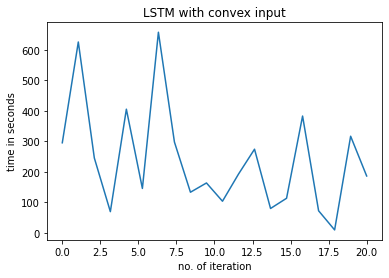

In [4]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, len(time_record), 20)
plt.plot(x, time_record)
plt.title("LSTM with convex input")
plt.xlabel("no. of iteration")
plt.ylabel("time in seconds")
plt.show()